In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#hide
from extract_patches.core import *

# Extract_patches

> Simple function for local patch extraction from local features keypoints. Accepts following formats:
> - OpenCV keypoints
> - Ellipse format \[x y a b c\], see further in [Oxford-Affine](http://www.robots.ox.ac.uk/~vgg/research/affine/detectors.html#binaries)
> - Affine features format [x y a11 a12 a21 a22], see further [here](https://www.vlfeat.org/overview/frame.html) 
> - OpenCV keypoints + A (a11 a12 a21, a22), say from [AffNet](https://github.com/ducha-aiki/affnet/) output

## Install

`pip install extract_patches`

## How to use

Fill me in please! Don't forget code examples:

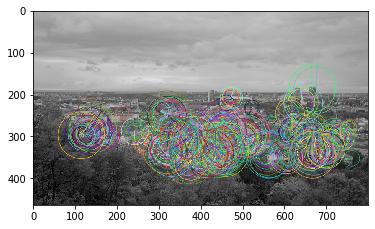

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2
import math
import seaborn as sns
from time import time
from PIL import Image

img1 = cv2.cvtColor(cv2.imread('img/prague.png'), cv2.COLOR_BGR2RGB)

det = cv2.ORB_create(500)
kps1, descs1 = det.detectAndCompute(img1,None)

vis_img1 = None
vis_img1 = cv2.drawKeypoints(cv2.cvtColor(img1,cv2.COLOR_RGB2GRAY),kps1,vis_img1, 
                             flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(vis_img1)

In [ ]:
from extract_patches.core import extract_patches

extract_patches performs extraction from the appropriate level of image pyramid, removing high freq artifacts. 
Border mode is set to "replicate", so the patch don't have crazy black borders

pyr OpenCV version for 500 kps, [s] 0.02819228172302246
<KeyPoint 0x7f5cf85b30c0>


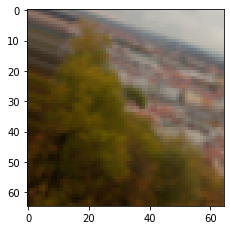

In [ ]:
show_idx = 300
PATCH_SIZE = 65
mrSize = 5.0
t=time()
patches = extract_patches(kps1, img1, PATCH_SIZE, mrSize, 'cv2')
print ('pyr OpenCV version for 500 kps, [s]', time()-t)
print (kps1[0])

fig = plt.figure(figsize=(12, 16))
fig.add_subplot(1, 3, 1) 
plt.imshow(patches[show_idx])

In [ ]:
#Now try with ellipse (x y a b c) format. Let`s download hessian affine from VGG website
!rm h_affine.ln
!wget http://www.robots.ox.ac.uk/~vgg/research/affine/det_eval_files/h_affine.ln.gz
!gunzip h_affine.ln.gz
!chmod +x h_affine.ln

rm: cannot remove 'h_affine.ln': No such file or directory
--2020-01-27 13:14:42--  http://www.robots.ox.ac.uk/~vgg/research/affine/det_eval_files/h_affine.ln.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3199317 (3.1M) [application/x-gzip]
Saving to: ‘h_affine.ln.gz’

h_affine.ln.gz      100%[===================>]   3.05M  4.51MB/s    in 0.7s    

2020-01-27 13:14:43 (4.51 MB/s) - ‘h_affine.ln.gz’ saved [3199317/3199317]



In [ ]:
!./h_affine.ln  -hesaff -i img/prague.png -o prague.hesaff -thres 100

hessian affine  detector...
cgood 1902 cbad 560 all 2462
cor nb 1679
detection time: 0.366667

number of points : 1562
output file: prague.hesaff


(1562, 5) [ 1.33920e+02  1.25280e+02  3.40137e-02 -2.62884e-02  9.84345e-02]
extract from ellipse features for 1500 kps, [s] 0.17285490036010742


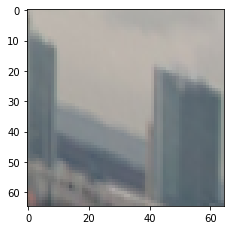

In [ ]:
ells = np.loadtxt('prague.hesaff', skiprows=2).astype(np.float32)
print (ells.shape, ells[0])

t=time()
patches_ells = extract_patches(ells, img1, PATCH_SIZE, mrSize, 'ellipse')
print ('extract from ellipse features for 1500 kps, [s]', time()-t)

fig = plt.figure(figsize=(12, 16))
fig.add_subplot(1, 3, 1) 
plt.imshow(patches_ells[1000])

In [ ]:
#And lets try x y a11 a12 a21 a22 format. MSER can output in it
!wget http://www.robots.ox.ac.uk/~vgg/research/affine/det_eval_files/mser.tar.gz
!tar -xf mser.tar.gz

--2020-01-27 13:17:56--  http://www.robots.ox.ac.uk/~vgg/research/affine/det_eval_files/mser.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 558415 (545K) [application/x-gzip]
Saving to: ‘mser.tar.gz’

mser.tar.gz         100%[===================>] 545.33K  2.72MB/s    in 0.2s    

2020-01-27 13:17:56 (2.72 MB/s) - ‘mser.tar.gz’ saved [558415/558415]



In [ ]:
#Extraction
!./mser.ln -i img/prague.png -o prague.mser  -t 4

def read_mser_file(fname):
    with open(fname, 'r') as f:
        out = []
        lines = f.readlines()
        num_feats1 = int(lines[0])
        num_feats2 = int(lines[0+num_feats1+1])
        for l in lines[1:num_feats1]:
            out.append(np.array([float(x) for x in l.strip().split(' ')]).reshape(1,-1))
        for l in lines[num_feats1+2:]:
            out.append(np.array([float(x) for x in l.strip().split(' ')]).reshape(1,-1))
    return np.concatenate(out,axis=0)[:,:6]
mser_xyA = read_mser_file('prague.mser')
print (mser_xyA.shape, mser_xyA[0])

(361, 6) [ 79.2818  410.027    12.2143   -3.72324  -3.72324   3.38642]


extract from a11, a12, a21, a22 features for 360 kps, [s] 0.031371116638183594


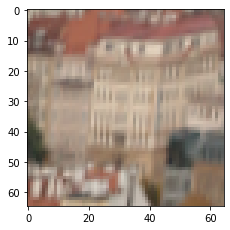

In [ ]:
t=time()
patches_mser = extract_patches(mser_xyA, img1, PATCH_SIZE, mrSize, 'xyA')
print ('extract from a11, a12, a21, a22 features for 360 kps, [s]', time()-t)

fig = plt.figure(figsize=(12, 16))
fig.add_subplot(1, 3, 1) 
plt.imshow(patches_mser[153])